In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
# from cudams import cosine, data, utils
from cudams.utils import argbatch, mkdir
from cudams.data import get_ref_spectra_from_df
from cudams.kernel import compile
from cudams.utils import name2idx
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from cudams.data import spectra_peaks_to_tensor
from cudams.processor import Config
from numba import cuda
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.size'] = 15

In [3]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 256

## GPU-specific constants
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

# Since Greedy cosine is an unstable algorithm, because approximate mz-mz values do not
# result in approximately the same scores and number of matches.
# So we need to use fp64 to minimize the deviation as much as possible.
# Using float32 causes a significant speedup in the processing speed.
dtype = 'float64'

# Data path
reference_csv_file = Path("data/input/example_dataset_tornike.csv")
query_csv_file = Path("data/input/example_dataset_tornike.csv")

# Limits
# We consider only first LIMIT number of entries in CSVs
LIMIT = 2048

# For keeping track of experiments

CONFIG = Config(
    tolerance = tolerance,
    shift = shift,
    mz_power = mz_power,
    int_power = int_power,
    dtype = dtype,
    reference_csv_file = reference_csv_file,
    query_csv_file = query_csv_file,
    BATCH_SIZE = BATCH_SIZE,
    MATCH_LIMIT = MATCH_LIMIT,
    LIMIT = LIMIT,
)

config_str = CONFIG.model_dump_json(indent=1)
experiment_hash = abs(hash(config_str))
output_dir = mkdir(Path(f'data/experiments/{experiment_hash}'))
(output_dir / 'config.json').write_text(config_str)
print(config_str)

{
 "tolerance": 0.1,
 "shift": 0.0,
 "mz_power": 0,
 "int_power": 1,
 "dtype": "float64",
 "reference_csv_file": "data/input/example_dataset_tornike.csv",
 "query_csv_file": "data/input/example_dataset_tornike.csv",
 "BATCH_SIZE": 1024,
 "MATCH_LIMIT": 256,
 "LIMIT": 2048
}


In [4]:
# We load CSV files using multiple threads
ref_spectra_df_path = Path(reference_csv_file)
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
references = get_ref_spectra_from_df(ref_spectra_df, limit=LIMIT)

query_spectra_df_path = Path(query_csv_file)
query_spectra_df = pd.read_csv(query_spectra_df_path)
queries = get_ref_spectra_from_df(query_spectra_df, limit=LIMIT)

print(f"We have {len(references)} references and {len(queries)} queries")

100%|██████████| 2048/2048 [00:00<00:00, 4890.09it/s]


We have 1993 references and 1993 queries


In [5]:
from cudams.cosine import similarity
from cudams.utils import argbatch

# ! rm -r data/tests/d7/*

cpu_output_dir = mkdir(output_dir / 'cpu', clean=True)

refs = list([r.peaks.to_numpy for r in references])
ques = list([q.peaks.to_numpy for q in queries])

rlims = argbatch(refs, BATCH_SIZE)
qlims = argbatch(ques, BATCH_SIZE)

batches_rq = list(product(rlims, qlims))

for (rstart, rend), (qstart, qend) in tqdm(batches_rq, total=len(batches_rq)):
    rspec = refs[rstart:rend]
    qspec = ques[qstart:qend]
    out_true = np.full((BATCH_SIZE, BATCH_SIZE, 2), fill_value=0, dtype='float32')
    for (i, spec1), (j, spec2) in product(enumerate(rspec), enumerate(qspec)):
            score = similarity(
                spec1,
                spec2,
                tolerance=tolerance,
                shift=shift,
                mz_power=mz_power,
                int_power=int_power,
            )
            if score is not None:
                out_true[i,j,0] = score[0]
                out_true[i,j,1] = score[1]
    np.save(cpu_output_dir / f'{rstart}-{rend}.{qstart}-{qend}.score.npy', out_true)

100%|██████████| 4/4 [00:26<00:00,  6.56s/it]


# Error analysis

In [6]:
R = math.ceil( len(references) / BATCH_SIZE ) * BATCH_SIZE
Q = math.ceil( len(queries) / BATCH_SIZE ) * BATCH_SIZE

C = np.empty((R,Q,2), dtype='float32')

scores = sorted(cpu_output_dir.glob('*.score.npy'))
for score in scores:
    rstart, rend, qstart, qend = name2idx(score)
    chunk = np.load(score)
    C[rstart:rend, qstart:qend] = chunk

In [7]:
print(output_dir)

data/experiments/7037845401422292691


In [43]:
from cudams.processor import CudaCosineGreedy

output_dir = mkdir(Path(f'data/experiments/{experiment_hash}'))
(output_dir / 'config.json').write_text(config_str)
print(output_dir)

cures = []
for MATCH_LIMIT in np.logspace(0, 9, 20, base=2, dtype='int'):
    MATCH_LIMIT = int(MATCH_LIMIT)
    kernel = compile(tolerance=tolerance, shift=shift, 
                    mz_power=mz_power, int_power=int_power, 
                    match_limit=MATCH_LIMIT, batch_size=BATCH_SIZE)
    ccg = CudaCosineGreedy(config=CONFIG, 
                           kernel=kernel, 
                           output_dir=mkdir(output_dir/'gpu'/str(MATCH_LIMIT), clean=True))
    cures.append([MATCH_LIMIT, ccg(references=references, queries=queries)])

data/experiments/7037845401422292691


Batch all references: 2it [00:00, 22.78it/s]
Batch all queries: 2it [00:00, 23.49it/s]
100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 27.27it/s]
Batch all queries: 2it [00:00, 27.50it/s]
100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 30.46it/s]
Batch all queries: 2it [00:00, 29.06it/s]
100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/1/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 21.72it/s]
Batch all queries: 2it [00:00, 26.61it/s]
100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/2/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/2/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/2/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/2/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/2/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/2/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/2/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/2/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 29.39it/s]
Batch all queries: 2it [00:00, 27.42it/s]
100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/3/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/3/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/3/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/3/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/3/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/3/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/3/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/3/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 17.45it/s]
Batch all queries: 2it [00:00, 25.99it/s]
100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/5/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/5/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/5/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/5/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/5/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/5/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/5/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/5/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 23.40it/s]
Batch all queries: 2it [00:00, 21.20it/s]
100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/7/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/7/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/7/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/7/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/7/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/7/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/7/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/7/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 30.23it/s]
Batch all queries: 2it [00:00, 30.22it/s]
100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/9/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/9/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/9/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/9/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/9/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/9/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/9/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/9/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 31.61it/s]
Batch all queries: 2it [00:00, 31.79it/s]
100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/13/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/13/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/13/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/13/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/13/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/13/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/13/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/13/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 27.72it/s]
Batch all queries: 2it [00:00, 28.94it/s]
100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/19/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/19/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/19/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/19/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/19/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/19/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/19/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/19/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 28.17it/s]
Batch all queries: 2it [00:00, 32.65it/s]
100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/26/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/26/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/26/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/26/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/26/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/26/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/26/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/26/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 30.63it/s]
Batch all queries: 2it [00:00, 28.85it/s]
100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/37/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/37/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/37/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/37/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/37/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/37/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/37/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/37/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 25.16it/s]
Batch all queries: 2it [00:00, 29.34it/s]
100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/51/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/51/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/51/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/51/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/51/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/51/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/51/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/51/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 28.13it/s]
Batch all queries: 2it [00:00, 32.30it/s]
100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/71/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/71/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/71/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/71/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/71/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/71/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/71/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/71/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 29.17it/s]
Batch all queries: 2it [00:00, 30.57it/s]
100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/99/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/99/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/99/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/99/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/99/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/99/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/99/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/99/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 29.85it/s]
Batch all queries: 2it [00:00, 33.88it/s]
100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/137/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/137/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/137/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/137/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/137/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/137/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/137/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/137/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 29.55it/s]
Batch all queries: 2it [00:00, 29.09it/s]
100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/191/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/191/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/191/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/191/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/191/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/191/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/191/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/191/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 30.15it/s]
Batch all queries: 2it [00:00, 28.60it/s]
100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/265/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/265/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/265/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/265/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/265/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/265/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/265/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/265/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 30.39it/s]
Batch all queries: 2it [00:00, 32.32it/s]
100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


[PosixPath('data/experiments/7037845401422292691/gpu/368/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/368/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/368/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/368/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/368/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/368/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/368/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/368/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 30.06it/s]
Batch all queries: 2it [00:00, 29.40it/s]
100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

[PosixPath('data/experiments/7037845401422292691/gpu/512/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/512/0-1024.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/512/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/512/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/512/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/512/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/7037845401422292691/gpu/512/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/7037845401422292691/gpu/512/1024-2048.1024-2048.score.npy')]
8 4


# Error analysis

In [47]:
x = []
y = []
for ml, res in tqdm(cures):
    s,ov = res.to_full_matrix()
    x.append(ml)
    y.append(ov.mean())

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 55.46it/s]

FILE HIT 0-1024.0-1024.ovfl 0 1024 0 1024
ovfl HIT data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.ovfl.npy 0-1024.0-1024.ovfl
FILE HIT 0-1024.0-1024.score 0 1024 0 1024
FILE HIT 0-1024.1024-2048.ovfl 0 1024 1024 2048
ovfl HIT data/experiments/7037845401422292691/gpu/1/0-1024.1024-2048.ovfl.npy 0-1024.1024-2048.ovfl
FILE HIT 0-1024.1024-2048.score 0 1024 1024 2048
FILE HIT 1024-2048.0-1024.ovfl 1024 2048 0 1024
ovfl HIT data/experiments/7037845401422292691/gpu/1/1024-2048.0-1024.ovfl.npy 1024-2048.0-1024.ovfl
FILE HIT 1024-2048.0-1024.score 1024 2048 0 1024
FILE HIT 1024-2048.1024-2048.ovfl 1024 2048 1024 2048
ovfl HIT data/experiments/7037845401422292691/gpu/1/1024-2048.1024-2048.ovfl.npy 1024-2048.1024-2048.ovfl
FILE HIT 1024-2048.1024-2048.score 1024 2048 1024 2048
FILE HIT 0-1024.0-1024.ovfl 0 1024 0 1024
ovfl HIT data/experiments/7037845401422292691/gpu/1/0-1024.0-1024.ovfl.npy 0-1024.0-1024.ovfl
FILE HIT 0-1024.0-1024.score 0 1024 0 1024
FILE HIT 0-1024.1024-2048.ovfl 0 

 85%|████████▌ | 17/20 [00:00<00:00, 45.98it/s]

FILE HIT 0-1024.0-1024.ovfl 0 1024 0 1024
ovfl HIT data/experiments/7037845401422292691/gpu/26/0-1024.0-1024.ovfl.npy 0-1024.0-1024.ovfl
FILE HIT 0-1024.0-1024.score 0 1024 0 1024
FILE HIT 0-1024.1024-2048.ovfl 0 1024 1024 2048
ovfl HIT data/experiments/7037845401422292691/gpu/26/0-1024.1024-2048.ovfl.npy 0-1024.1024-2048.ovfl
FILE HIT 0-1024.1024-2048.score 0 1024 1024 2048
FILE HIT 1024-2048.0-1024.ovfl 1024 2048 0 1024
ovfl HIT data/experiments/7037845401422292691/gpu/26/1024-2048.0-1024.ovfl.npy 1024-2048.0-1024.ovfl
FILE HIT 1024-2048.0-1024.score 1024 2048 0 1024
FILE HIT 1024-2048.1024-2048.ovfl 1024 2048 1024 2048
ovfl HIT data/experiments/7037845401422292691/gpu/26/1024-2048.1024-2048.ovfl.npy 1024-2048.1024-2048.ovfl
FILE HIT 1024-2048.1024-2048.score 1024 2048 1024 2048
FILE HIT 0-1024.0-1024.ovfl 0 1024 0 1024
ovfl HIT data/experiments/7037845401422292691/gpu/37/0-1024.0-1024.ovfl.npy 0-1024.0-1024.ovfl
FILE HIT 0-1024.0-1024.score 0 1024 0 1024
FILE HIT 0-1024.1024-2048.ov

100%|██████████| 20/20 [00:00<00:00, 46.89it/s]

FILE HIT 0-1024.0-1024.score 0 1024 0 1024
FILE HIT 0-1024.1024-2048.ovfl 0 1024 1024 2048
ovfl HIT data/experiments/7037845401422292691/gpu/512/0-1024.1024-2048.ovfl.npy 0-1024.1024-2048.ovfl
FILE HIT 0-1024.1024-2048.score 0 1024 1024 2048
FILE HIT 1024-2048.0-1024.ovfl 1024 2048 0 1024
ovfl HIT data/experiments/7037845401422292691/gpu/512/1024-2048.0-1024.ovfl.npy 1024-2048.0-1024.ovfl
FILE HIT 1024-2048.0-1024.score 1024 2048 0 1024
FILE HIT 1024-2048.1024-2048.ovfl 1024 2048 1024 2048
ovfl HIT data/experiments/7037845401422292691/gpu/512/1024-2048.1024-2048.ovfl.npy 1024-2048.1024-2048.ovfl
FILE HIT 1024-2048.1024-2048.score 1024 2048 1024 2048


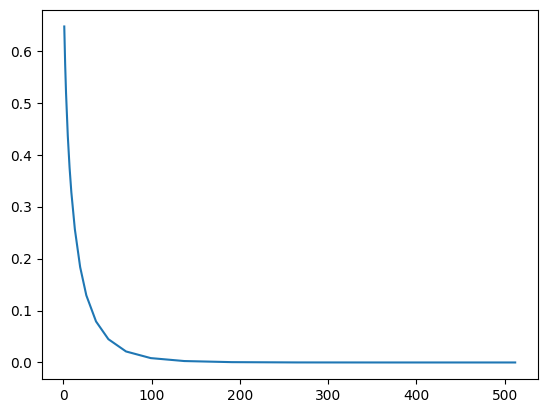

In [48]:
plt.plot(x,y)

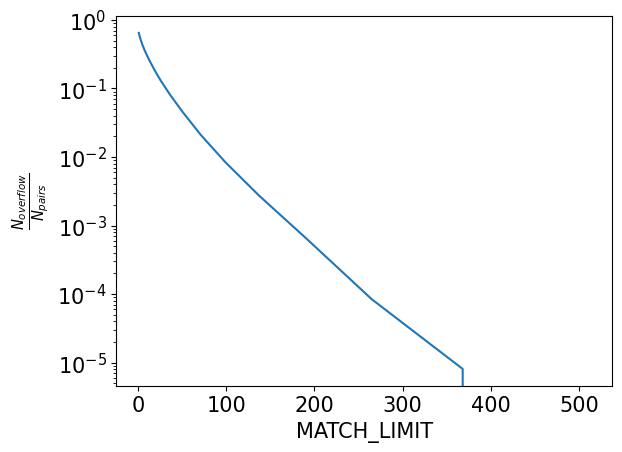

In [74]:
plt.semilogy(x,y)
plt.xlabel("MATCH_LIMIT")
plt.ylabel(r"$\frac{N_{overflow}}{N_{pairs}}$")
plt.show();

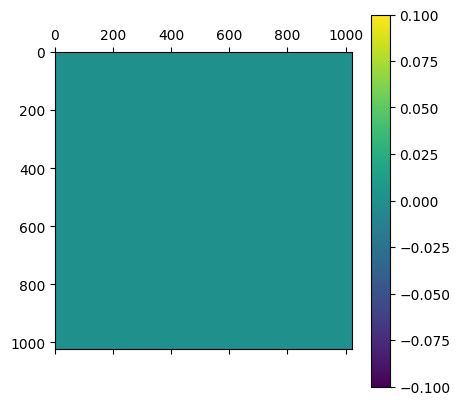

In [23]:
plt.matshow(x.squeeze())
plt.colorbar()

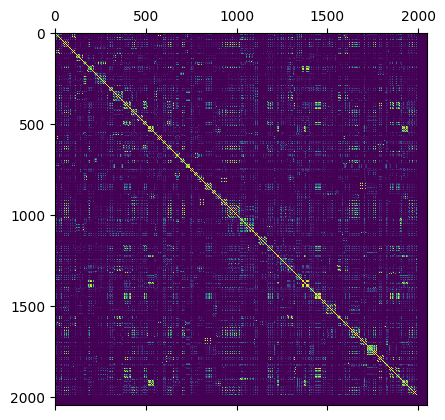

In [17]:
import matplotlib.pyplot as plt
plt.matshow(s[...,0])

In [19]:
experiment_hash

7037845401422292691

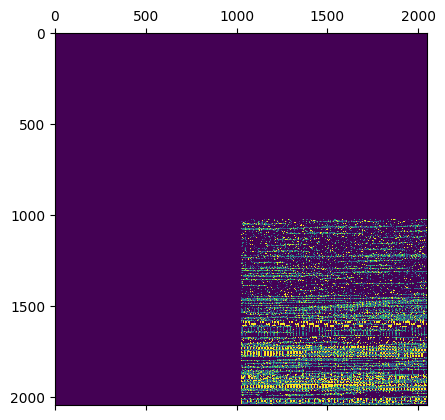

In [18]:
plt.matshow(ov.squeeze())